In [1]:
### FEATURE SELECTION ON THREE SEPARATE DATASETS ###

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier, LinearRegression
from sklearn.feature_selection import SelectFromModel

In [2]:
# load datasets

fifty_neither_vs_mel_keratosis = pd.read_csv('../dataset_versions/50neither_vs_mel_keratosis.csv')
mel_vs_keratosis = pd.read_csv('../dataset_versions/mel_vs_keratosis.csv')
neither_vs_melkeratosis = pd.read_csv('../dataset_versions/neither_vs_melkeratosis.csv')
print(len(fifty_neither_vs_mel_keratosis.columns), len(mel_vs_keratosis.columns), len(neither_vs_melkeratosis.columns))

108 107 107


In [3]:
fnmk_features = fifty_neither_vs_mel_keratosis.drop(["melanoma", "seborrheic_keratosis", "neither",'age_approximate', 'sex'], axis=1)
mk_features = mel_vs_keratosis.drop(["melanoma", "seborrheic_keratosis", 'age_approximate', 'sex'], axis=1)
nm_features = neither_vs_melkeratosis.drop(["mel_keratosis", "neither", 'age_approximate', 'sex'], axis=1)

FEATURE SELECTION BASED ON CORRELATION.
To remove redundant features, drop those who are highly correlated

In [4]:
# Function to extract the features with correlation over a threshold
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = dataset.corr(numeric_only=1)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold: # We are interested in abs coeff value
                colname = corr_matrix.columns[i] # getting the name of the column
                col_corr.add(colname)
    return col_corr

In [5]:
# extract correlated features
fnmk_corr_features = correlation(fnmk_features, 0.9)
mk_corr_features = correlation(mk_features, 0.9)
nm_corr_features = correlation(nm_features, 0.9)

# drop correlated features
fnmk_best_features = fnmk_features.drop(fnmk_corr_features, axis=1)
mk_best_features = mk_features.drop(mk_corr_features, axis=1)
nm_best_features = nm_features.drop(nm_corr_features, axis=1)
print(len(fnmk_best_features.columns),len(mk_best_features.columns), len(nm_best_features.columns))

44 40 44


FEATURE SELECTION BASED ON VARIANCE
Remove features that have low variance (no impact on the target) and those with too high variance (pyradiomics algorithm outputting excentric values) 

Importance of variance in machine learning model development
van der Putten, P., van Someren, M. A Bias-Variance Analysis of a Real World Learning Problem: The CoIL Challenge 2000. Machine Learning 57, 177–195 (2004). https://doi.org/10.1023/B:MACH.0000035476.95130.99

Feature com variância máxima: 2782471134808382.5 Feature com variância mínima: 3.62825227457758e-05


/tmp/ipykernel_44071/20682678.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  va = fnmk_best_features.var(ddof=0)
/tmp/ipykernel_44071/20682678.py:5: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.boxplot(np.log10(fnmk_best_features.var(ddof=0)),autorange=True, labels=['Features'])


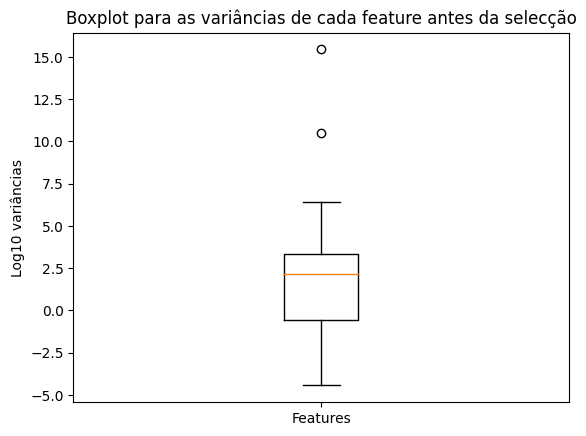

In [6]:
va = fnmk_best_features.var(ddof=0)
print('Feature com variância máxima: ' + str(max(list(va))), 'Feature com variância mínima: ' + str(min(list(va))))

### plot variance of current features
plt.boxplot(np.log10(fnmk_best_features.var(ddof=0)),autorange=True, labels=['Features'])
# Add title and axis names
plt.title('Boxplot para as variâncias de cada feature antes da selecção')
plt.ylabel('Log10 variâncias')
plt.savefig('../plots/feature_variance_before_selection.png', bbox_inches='tight')
# Show graph
plt.show()


In [7]:
# function to remove features based on variance outliers
## this function calculates the variance for each feature, appends the values to a list and removes features
## lower and upper outliers. If a feature as too high ou too low variance, it is removed

def feature_selection_variance(data):
    variance_list = []
    
    for i in data.columns[1:]:
        variance_list.append(data[i].var(ddof=0))

    variance_q1 = np.quantile(variance_list, 0.25)
    variance_q3 = np.quantile(variance_list, 0.75)
    variance_med = np.median(variance_list)
    variance_iqr = variance_q3 - variance_q1
    variance_ub = variance_q3 + (1.5 * variance_iqr)
    variance_lb = variance_q1 - (1.5 *  variance_iqr)
    variance_outliers = [v for v in variance_list if v <= variance_lb or v >= variance_ub]
    
    for u in data.columns[1:]:
        if data[u].var(ddof=0) in variance_outliers:
            data = data.drop(u, axis=1)
    
    return data

In [8]:
# remove outlier features from the datasets

fnmk_best_features = feature_selection_variance(fnmk_best_features)
mk_best_features = feature_selection_variance(mk_best_features)
nm_best_features = feature_selection_variance(nm_best_features)
print(len(fnmk_best_features.columns),len(mk_best_features.columns), len(nm_best_features.columns))
fnmk_best_features.head()

36 34 36


,image_id,red_mode,green_mode,blue_mode,red_iqr,green_iqr,blue_iqr,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Entropy,...,original_gldm_DependenceNonUniformityNormalized,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_ZoneEntropy,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,ISIC_0000001,87,53,46,86,58,40,112.0,135.0,1.163592,...,0.319269,4.672684,0.974713,1.455006,0.299423,0.455025,2.777913,0.808480,0.006020,0.124740
1,ISIC_0000002,162,120,114,26,52,67,157.0,169.0,0.112792,...,0.306757,5.051852,1.278172,1.499710,0.380191,0.415954,1.932127,0.007574,0.000012,0.941026
2,ISIC_0000003,182,128,51,60,57,48,176.0,191.0,0.360618,...,0.302680,5.162065,1.407530,1.505587,0.429752,0.434164,2.214528,0.119264,0.000637,0.080628
3,ISIC_0000004,192,132,171,36,44,55,26.0,205.0,2.589392,...,0.322044,4.673329,0.806039,1.548163,0.268533,0.432653,4.275156,3.153283,0.021736,2.213424
4,ISIC_0000007,153,108,87,46,70,83,134.0,146.0,0.130615,...,0.319799,4.842105,1.259935,1.550411,0.397945,0.408983,1.894236,0.037263,0.000061,0.416268


/tmp/ipykernel_44071/2467523384.py:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.boxplot(np.log10(fnmk_best_features.var(ddof=0)))
/tmp/ipykernel_44071/2467523384.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "labels" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../plots/feature_variance_after_selection.png', labels=['Features'], bbox_inches='tight')


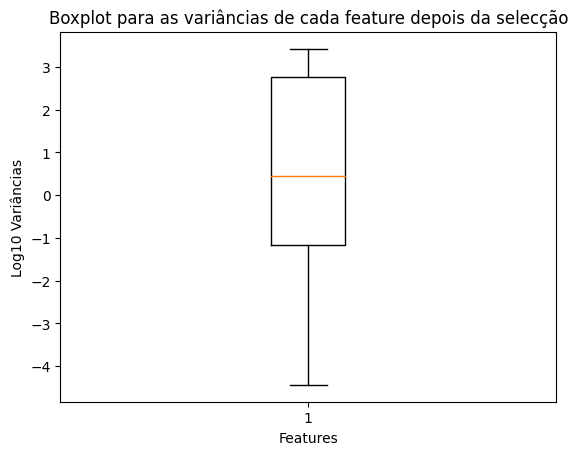

In [9]:
### plot variance of current features
plt.boxplot(np.log10(fnmk_best_features.var(ddof=0)))
# Add title and axis names
plt.title('Boxplot para as variâncias de cada feature depois da selecção')
plt.xlabel('Features')
plt.ylabel('Log10 Variâncias')
plt.savefig('../plots/feature_variance_after_selection.png', labels=['Features'], bbox_inches='tight')
# Show graph
plt.show()


FEATURE SELECTION USING LINEAR MODELS TO DETERMINE THE MOST RELEVANT FEATURES

In [10]:
# append target columns to selected features dataframe
fifty_neither_vs_mel_keratosis_features_targets = fnmk_best_features.join(fifty_neither_vs_mel_keratosis[["melanoma","seborrheic_keratosis","neither"]])
mel_vs_keratosis_features_targets = mk_best_features.join(mel_vs_keratosis[["melanoma", "seborrheic_keratosis"]])
neither_vs_melkeratosis_features_targets = nm_best_features.join(neither_vs_melkeratosis[["mel_keratosis", "neither"]])

In [11]:
### FEATURE SELECION BASED ON A MODEL. A RIDGE CLASSIFIER (Least Squares SVM) we'll be used to extract
### the most important features

In [12]:
X = neither_vs_melkeratosis_features_targets.iloc[:,1:-2]
y = neither_vs_melkeratosis_features_targets[['mel_keratosis','neither']]
feature_selector_from_model_a = SelectFromModel(estimator=RidgeClassifier(solver='lsqr')).fit(X, y)
feature_selector_from_model_a.get_feature_names_out()

array(['red_median', 'red_iqr', 'green_iqr',
       'original_firstorder_10Percentile',
       'original_firstorder_90Percentile',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Range', 'original_glcm_Autocorrelation',
       'original_gldm_LargeDependenceEmphasis',
       'original_glrlm_LongRunEmphasis',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_ngtdm_Strength'],
      dtype=object)

In [13]:
X = mel_vs_keratosis_features_targets.iloc[:,1:-2]
y = mel_vs_keratosis_features_targets[['melanoma', 'seborrheic_keratosis']]
feature_selector_from_model_b = SelectFromModel(estimator=RidgeClassifier(solver='lsqr')).fit(X, y)
feature_selector_from_model_b.get_feature_names_out()

array(['blue_iqr', 'original_firstorder_Entropy',
       'original_firstorder_Skewness',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_ngtdm_Complexity',
       'original_ngtdm_Strength'], dtype=object)

In [14]:
X = fifty_neither_vs_mel_keratosis_features_targets.iloc[:,1:-3]
y = fifty_neither_vs_mel_keratosis_features_targets[["melanoma","seborrheic_keratosis","neither"]]
feature_selector_from_model_c = SelectFromModel(estimator=RidgeClassifier(solver='lsqr')).fit(X, y)
feature_selector_from_model_c.get_feature_names_out()

array(['green_iqr', 'blue_iqr', 'original_firstorder_Skewness',
       'original_glcm_Autocorrelation', 'original_glcm_Imc1',
       'original_glcm_Imc2', 'original_gldm_LargeDependenceEmphasis',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glrlm_LongRunLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_ngtdm_Complexity',
       'original_ngtdm_Strength'], dtype=object)

In [15]:
# get only selected features with the image id and the targets

to_keep_a = list(feature_selector_from_model_a.get_feature_names_out())
to_keep_a.insert(0,'image_id')
to_keep_a.extend(['mel_keratosis','neither'])
neither_vs_melkeratosis_features_targets = neither_vs_melkeratosis_features_targets[to_keep_a]


to_keep_b = list(feature_selector_from_model_b.get_feature_names_out())
to_keep_b.insert(0, 'image_id')
to_keep_b.extend(['melanoma', 'seborrheic_keratosis'])
mel_vs_keratosis_features_targets = mel_vs_keratosis_features_targets[to_keep_b]


to_keep_c = list(feature_selector_from_model_c.get_feature_names_out())
to_keep_c.insert(0, 'image_id')
to_keep_c.extend(["melanoma","seborrheic_keratosis","neither"])
fifty_neither_vs_mel_keratosis_features_targets = fifty_neither_vs_mel_keratosis_features_targets[to_keep_c]


In [16]:
# save final features along with images and targets to csv
neither_vs_melkeratosis_features_targets.to_csv('../neither_vs_melkeratosis_features_targets.csv', index=False)
mel_vs_keratosis_features_targets.to_csv('../mel_vs_keratosis_features_targets.csv', index=False)
fifty_neither_vs_mel_keratosis_features_targets.to_csv('../fifty_neither_vs_mel_keratosis_features_targets.csv', index=False)

In [59]:
feat_selection_before = [ len(fnmk_features.columns.unique())-1, len(mk_features.columns.unique())-1, len(nm_features.columns.unique())-1]

In [60]:
feat_selection_after_corr = [ len(fnmk_best_features.columns.unique()), len(mk_best_features.columns.unique()), len(nm_best_features.columns.unique())]

In [61]:
feat_selection_after_var_model = [len(feature_selector_from_model_c.get_feature_names_out()), len(feature_selector_from_model_b.get_feature_names_out()), len(feature_selector_from_model_a.get_feature_names_out())]

In [62]:
print(feat_selection, feat_selection_after_corr, feat_selection_after_var_model)

[103, 103, 103] [36, 34, 36] [12, 7, 13]


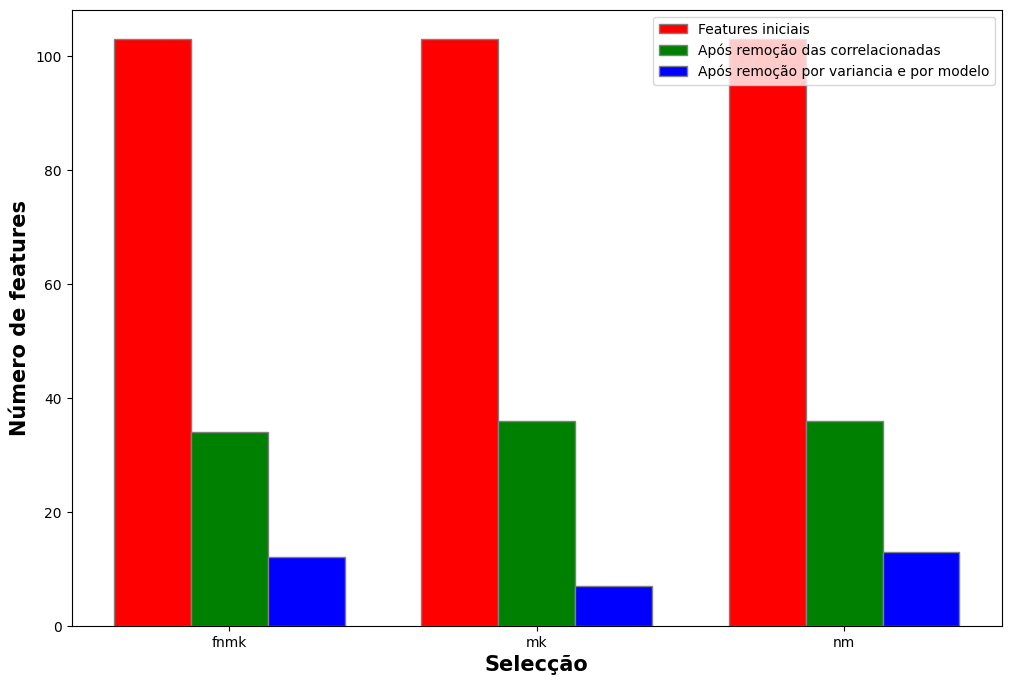

In [65]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize = (12, 8))

# set height of bar
initial_features = [103, 103, 103]
after_corr = [34, 36, 36]
after_var_model = [12, 7, 13]

# Set position of bar on X axis
br1 = np.arange(len(initial_features))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]   

# Make the plot
plt.bar(br1, initial_features, color ='r', width = barWidth, edgecolor ='grey', label ='Features iniciais')
plt.bar(br2, after_corr, color ='g', width = barWidth, edgecolor ='grey', label ='Após remoção das correlacionadas')
plt.bar(br3, after_var_model , color ='b', width = barWidth, edgecolor ='grey', label ='Após remoção por variancia e por modelo')

# Adding Xticks
plt.xlabel('Selecção', fontweight ='bold', fontsize = 15)
plt.ylabel('Número de features', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(initial_features))],['fnmk', 'mk', 'nm'])   
plt.legend()
plt.savefig('../plots/feature_selection_barplot.png', bbox_inches='tight')
plt.show()